Feature Engineering 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

In [2]:
df = pd.read_parquet('../data/Silver/eda_enriched.parquet')
print('data was loaded')

data was loaded


In [4]:
df.shape

(31898218, 19)

In [5]:
print(f"\nLaundering rate: {df['Is Laundering'].mean()*100:.4f}%")
print(f"\nColumns: {list(df.columns)}")


Laundering rate: 0.1104%

Columns: ['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering', 'hour', 'day_of_week', 'date', 'is_weekend', 'is_night', 'is_cross_currency', 'is_round_1000', 'is_round_100']


Feature Engineering: High-Value Risk Indicators

**Based on EDA :**
- ACH Payment Format: 7x risk
- Weekend Transactions: 3x risk
- UK Pound + Just-Below-Threshold: 8x risk
- Bank 1004 Pattern: Very high risk
- Structuring Range ($3K-$9K): Moderate risk

In [ ]:
# Payment Format Features (ACH = 7.15x,UK Pound = 8.3x, Euro = 2.2x, USD = 2.0x)risk)
df['is_ach'] = (df['Payment Format'] == 'ACH').astype(int)

In [9]:
# Amount-Based Features 
df['is_just_below_threshold'] = 0
for currency in ['US Dollar', 'Euro', 'UK Pound', 'Canadian Dollar', 'Australian Dollar']:
    mask = (df['Payment Currency'] == currency) & \
           (df['Amount Paid'] >= 9000) & \
           (df['Amount Paid'] < 10000)
    df.loc[mask, 'is_just_below_threshold'] = 1

df['in_structuring_range'] = ((df['Amount Paid'] >= 3000) & (df['Amount Paid'] <= 9000)).astype(int)
df['amount_zscore'] = (df['Amount Paid'] - df['Amount Paid'].mean()) / df['Amount Paid'].std()

In [8]:
# Account Features (Bank 1004 vs 800 pattern)
df['account_prefix'] = df['Account'].astype(str).str[:4]
df['is_bank_1004'] = (df['account_prefix'] == '1004').astype(int)
df['is_bank_800'] = (df['account_prefix'].str.startswith('800')).astype(int)

In [10]:
# Currency-Specific Risk Flags
df['is_uk_pound'] = (df['Payment Currency'] == 'UK Pound').astype(int)
df['is_euro'] = (df['Payment Currency'] == 'Euro').astype(int)
df['is_usd'] = (df['Payment Currency'] == 'US Dollar').astype(int)


In [11]:
# High-Risk Flags
df['uk_pound_structuring'] = (df['is_uk_pound'] * df['is_just_below_threshold']).astype(int)
df['ach_weekend'] = (df['is_ach'] * df['is_weekend']).astype(int)

In [ ]:
#  Risk Score (Based on EDA findings)
df['risk_score_v2'] = (
    df['is_ach'] * 7 +                      
    df['uk_pound_structuring'] * 8 +        
    df['is_weekend'] * 3 +                 
    df['is_just_below_threshold'] * 2 +    
    df['in_structuring_range'] * 1 +        
    df['is_bank_1004'] * 5                  
)

Feature Engineering summary

In [14]:
df.shape

(31898218, 32)

In [13]:
print(f"\nNew Features Created: {len([col for col in df.columns if col not in ['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering']])}")


New Features Created: 21


In [15]:
print(f"is_ach: {df['is_ach'].sum():,} transactions")
print(f"is_weekend: {df['is_weekend'].sum():,} transactions")
print(f"is_just_below_threshold: {df['is_just_below_threshold'].sum():,} transactions")

is_ach: 3,868,404 transactions
is_weekend: 3,325,397 transactions
is_just_below_threshold: 201,268 transactions


In [16]:
print(f"in_structuring_range: {df['in_structuring_range'].sum():,} transactions")
print(f"is_bank_1004: {df['is_bank_1004'].sum():,} transactions")
print(f"uk_pound_structuring: {df['uk_pound_structuring'].sum():,} transactions")
print(f"ach_weekend: {df['ach_weekend'].sum():,} transactions")

in_structuring_range: 4,009,300 transactions
is_bank_1004: 2,960,783 transactions
uk_pound_structuring: 9,117 transactions
ach_weekend: 477,374 transactions


Risk Score Analysis

In [17]:
risk_score_analysis = df.groupby('risk_score_v2').agg({
    'Is Laundering': ['sum', 'count', 'mean']
})

risk_score_analysis.columns = ['Laundering_Count', 'Total_Txns', 'Laundering_Rate']
risk_score_analysis['Laundering_Rate_Pct'] = risk_score_analysis['Laundering_Rate'] * 100

print("Risk Score V2 Distribution")
risk_score_analysis.head(15)

Risk Score V2 Distribution


,Laundering_Count,Total_Txns,Laundering_Rate,Laundering_Rate_Pct
risk_score_v2,,,,
0,211,19596180,0.0000,0.0011
1,14,2794971,0.0000,0.0005
2,1,140846,0.0000,0.0007
3,63,2231671,0.0000,0.0028
4,5,285331,0.0000,0.0018
5,3277,2282986,0.0014,0.1435
6,463,355186,0.0013,0.1304
7,15200,2935626,0.0052,0.5178
8,6518,731110,0.0089,0.8915


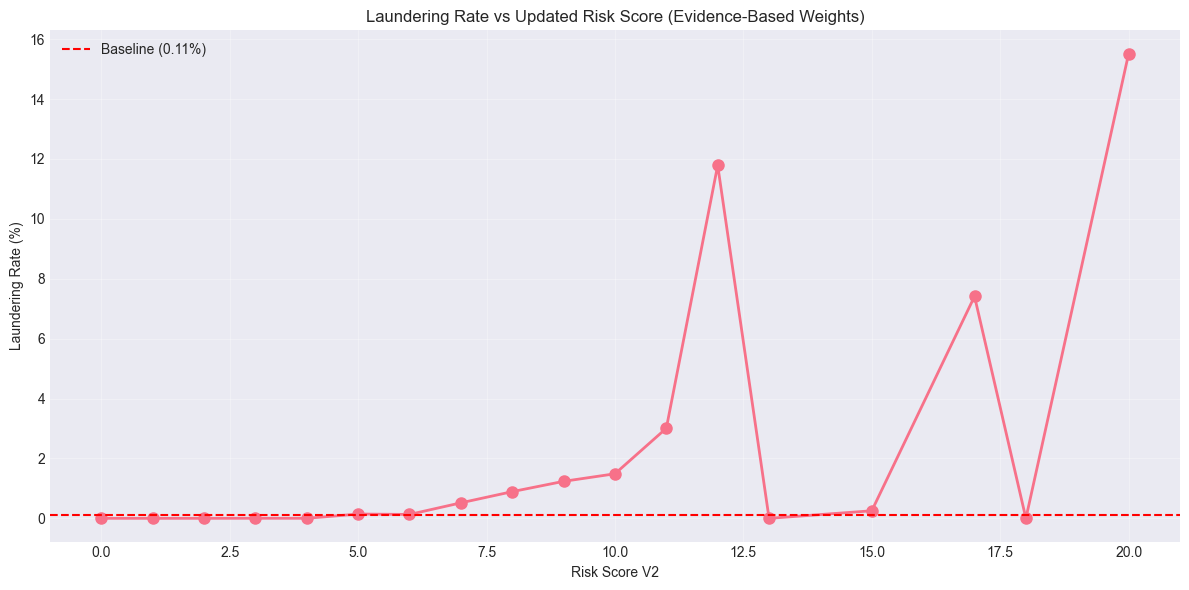

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(risk_score_analysis.index, risk_score_analysis['Laundering_Rate_Pct'], marker='o', linewidth=2, markersize=8)
plt.xlabel('Risk Score V2')
plt.ylabel('Laundering Rate (%)')
plt.title('Laundering Rate vs Updated Risk Score (Evidence-Based Weights)')
plt.grid(True, alpha=0.3)
plt.axhline(df['Is Laundering'].mean()*100, color='red', linestyle='--', label='Baseline (0.11%)')
plt.legend()
plt.tight_layout()
plt.show()

Save to Gold Layer

In [19]:
df.shape

(31898218, 32)

In [20]:
df.to_parquet('../data/Gold/features_engineered.parquet', index=False, compression='snappy')
print(f"Feature-engineered data saved")

Feature-engineered data saved
